# CS 109B - Course Project - Team 14
## Text Mining - The Movie Database - Movie Overviews

In [76]:
import numpy as np
import os.path as op
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split as sk_split
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.io import mmwrite
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC

from IPython.display import display, HTML, Markdown
%matplotlib inline
plt.style.use('ggplot') 
def printmd(string):
    display(Markdown(string))

In [2]:
genres = ["Action", "Adventure", "Animation", "Comedy", "Crime", "Doc", "Drama", \
            "Family", "Fantasy", "History", "Horror", "Music", "Mystery", \
          "Romance", "Sci_Fi", "Thriller", "War", "Western"]

num_genres = len(genres)
num_non_genre_cols = 2

train_percent = 80

## Step 1: Load and Clean Data

In [3]:
# helper function to select the columns of interest from the data set
def Select_Data(data):
    
    features_to_select = ["overview", 'imdb_id'] + genres
    data_select = data[features_to_select]
    data_select.columns = ["Overview", "Imdb_Id"] + genres
    
    return data_select

In [4]:
# helper function to filter the data set down to rows of interest
def Filter_Data(data):
    
    # set flags for filtering
    status_flags =  ~data.Overview.isnull() & \
                    ~data.Overview.str.match('NA', na = False)          
                
    # filter rows per flags above
    data_filter = data.ix[status_flags, :].reset_index(drop = True)
    
    return data_filter

In [5]:
# helper function to clean data
def Clean_Data(data):
    data_clean = data.copy()
    data_clean.Overview = data_clean.Overview.str.replace("\n|\r", ' ')
        
    return data_clean

In [6]:
def Preprocess_Dataset():
    clean_data_filename = "clean_tmdb_data_with_Y.csv"

    # preprocess data set and save result as new file
    if not op.isfile(clean_data_filename):
        data_raw = pd.read_csv("tmdb_data_with_Y.csv")
        data_select = Select_Data(data_raw)
        data_filter = Filter_Data(data_select)
        data_clean = Clean_Data(data_filter)
        data_clean.to_csv(clean_data_filename, index = False)

    # read pre-processed sample data file
    data_clean2 = pd.read_csv(clean_data_filename)
        
    return data_clean2

In [7]:
# pre-process or load data for analysis
data = Preprocess_Dataset()   

# set boolean and string column data types
data.Overview = data.Overview.astype('str')

# split data into train vs. test sets
data_train, data_test = sk_split(data, train_size = train_percent / 100.0)

In [8]:
# get overview of data
print
print("Data dimensions: " + str(data_train.shape))
display(data_train.head())


Data dimensions: (26451, 20)


,Overview,Imdb_Id,Action,Adventure,Animation,Comedy,Crime,Doc,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Sci_Fi,Thriller,War,Western
14562,"When Martians suddenly abduct his mom, mischie...",1305591,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32013,"Lorsque Julien Foucault, maître d'hôtel de la ...",1314240,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27122,"Elmer does not want to leave Gentryville, beca...",23982,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21392,Odessa is a beautiful girl addicted to the att...,1031658,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17691,"Double the Girls, Double the Guns!! For Mikura...",427531,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# summarize data
data_train.describe()

,Imdb_Id,Action,Adventure,Animation,Comedy,Crime,Doc,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Sci_Fi,Thriller,War,Western
count,2.645100e+04,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000,26451.000000
mean,8.451764e+05,0.140222,0.063816,0.036256,0.299044,0.087256,0.094552,0.477222,0.055385,0.041322,0.030547,0.108918,0.034101,0.048202,0.159540,0.061170,0.170164,0.028997,0.025784
std,1.131472e+06,0.347223,0.244430,0.186929,0.457848,0.282215,0.292601,0.499490,0.228735,0.199037,0.172090,0.311543,0.181492,0.214198,0.366186,0.239646,0.375784,0.167801,0.158492
min,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.921150e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.572900e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.356579e+06,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.098922e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 2: Create NLP Features

In [10]:
# copy data for processing
data_nlp_train = data_train.copy()
data_nlp_test = data_test

### Process Text

For the training data, we proceed with the following steps:
    
1. Stem words to reduce noise in the data
2. Fit a count vectorizer and build a document-term matrix
3. Fit principal components and reduce the data

Using a TF-IDF vectorizer, rather than a count vectorizer, gives similar prediction accuracy with this data set (not reported here). So we'll focus on the simpler counting approach for the remainder of this analysis.

In [11]:
### set up word stemming

from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language = 'english', ignore_stopwords = True)
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def take(n, seq):
    seq = iter(seq)
    result = []
    try:
        for i in range(n):
            result.append(seq.next())
    except StopIteration:
        pass
    
    return result

#### Training Data

In [12]:
# stem words in Overview field (train)
for index in range(data_nlp_train.shape[0]):
    data_nlp_train.Overview.values[index] = \
        " ".join(take(1000, stemmed_words(data_nlp_train.Overview.values[index])))

In [13]:
# create n-grams from overview (train)
vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1, 1))
vectorizer.fit(data_nlp_train.Overview.values)
over_matrix_train = vectorizer.transform(data_nlp_train.Overview.values)
n, p = over_matrix_train.shape
print over_matrix_train.shape

# term_freqs_file = "term_freqs.mtx"
#if not op.isfile(term_freqs_file):
#    mmwrite(term_freqs_file, over_matrix_train)

(26451, 43113)


In [14]:
# apply SVD to document-term matrix (train)
tsvd = tSVD(n_components = 100)
tsvd.fit(over_matrix_train)
over_matrix_pca_train = tsvd.transform(over_matrix_train)
print
print("Cumulative percentage of variance explained: " + \
      str(round(tsvd.explained_variance_ratio_.sum(), 4)))


Cumulative percentage of variance explained: 0.215


In [15]:
pc1 = tsvd.components_[1]
pc1_top_loadings = np.where(pc1 > 10**-1.75)

#### Testing Data

Vectorizer and principal-components transformations of the testing data are performed using fits from the training data.

In [16]:
# stem words in Overview field (test)
for index in range(data_nlp_test.shape[0]):
    data_nlp_test.Overview.values[index] = \
        " ".join(take(1000, stemmed_words(data_nlp_test.Overview.values[index])))

# create n-grams from overview (test)
over_matrix_test = vectorizer.transform(data_nlp_test.Overview.values)

# apply SVD to document-term matrix (test)
over_matrix_pca_test = tsvd.transform(over_matrix_test)

### Explore Terms

In [17]:
# print sample terms from overview
feature_names = np.array(vectorizer.get_feature_names()).reshape(-1, 1)
print "Total number of overviews and terms: " + str(n) + " overviews and " \
    + str(p) + " terms"
print
terms_df = pd.DataFrame(feature_names[1000:1010, 0], 
                        columns = ['Sample_Stemmed_Terms'])
display(terms_df)

Total number of overviews and terms: 26451 overviews and 43113 terms



,Sample_Stemmed_Terms
0,adan
1,adana
2,adanggaman
3,adap
4,adapt
5,adar
6,add
7,addam
8,addendum
9,adderal


In [18]:
# count words and vocabulary per overview
data_nlp_train.Word_Count = over_matrix_train.sum(axis = 1)
data_nlp_train.Vocab_Count = (over_matrix_train > 0).sum(axis = 1)

In [19]:
# create term dictionary
all_term_dict = zip(vectorizer.get_feature_names(),
                    np.asarray(over_matrix_train.sum(axis = 0)).ravel())
all_term_dict_df = pd.DataFrame(all_term_dict).sort_values(by = [1], 
                                                           ascending = False)

In [20]:
# list top terms in dictionary
print
print "Most frequent stemmed terms in overviews"
all_term_dict_df.columns = ['Stemmed_Term', 'Count']
all_term_dict_df.reset_index(drop = True).head(20)


Most frequent stemmed terms in overviews


,Stemmed_Term,Count
0,life,4858
1,film,4108
2,young,3955
3,year,3870
4,love,3724
5,live,3637
6,man,3421
7,new,3367
8,stori,3206
9,famili,3164


In [21]:
terms_df = pd.DataFrame(feature_names[pc1_top_loadings], columns = ['Term'])
printmd("#### Top loadings (terms) of principal component 1:")
printmd(terms_df.Term.str.cat(sep = ', '))

#### Top loadings (terms) of principal component 1:

actor, adapt, american, anim, award, base, charact, cinema, comedi, creat, cultur, direct, director, documentari, drama, explor, featur, festiv, fiction, film, filmmak, follow, footag, histori, includ, interview, movi, music, narrat, novel, origin, peopl, play, produc, product, releas, role, scene, seri, set, short, shot, star, stori, tell, war, world, written

These top loadings show a variety of terms used to distinguish one genre from another. A few genre name stems appear among the top loadings, including 'anim', 'drama', 'comedi', 'documentari', 'histori', and 'music'. Other key term stems include 'war' and 'world'.

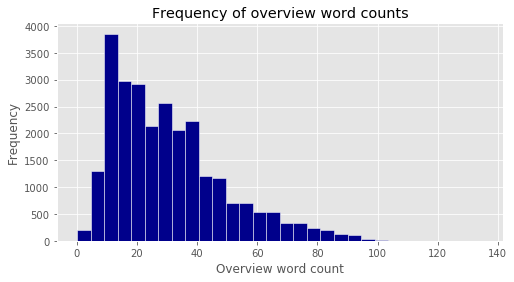

In [22]:
# plot histogram of word counts per overview
print
fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp_train.Word_Count, bins = 30, color = 'darkblue', 
        edgecolor = 'white')
ax.set_title("Frequency of overview word counts")
ax.set_xlabel("Overview word count")
ax.set_ylabel("Frequency")
plt.show()

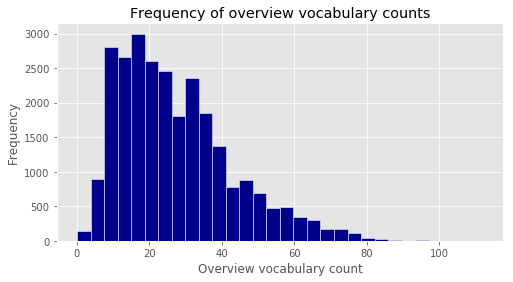

In [23]:
# plot histogram of vocabulary counts per overview
print
fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_nlp_train.Vocab_Count, bins = 30, color = 'darkblue', 
        edgecolor = 'white')
ax.set_title("Frequency of overview vocabulary counts")
ax.set_xlabel("Overview vocabulary count")
ax.set_ylabel("Frequency")
plt.show()

## Step 3: Modeling

Accuracy is comparably good using either a random forest (RF) classifier or quadratic discriminant analysis (QDA). Let's proceed with RF, since it slightly outscores QDA by about 1%. The success of QDA implies that a quadratic decision boundary is effective for predicting individual genre with this data set. The success of QDA also implies that tagging by any single genre follows a Gaussian distribution.

Another popular machine learning algorithm, logistic regression, showed prediction accuracy about 5% less than either RF or QDA. So we'll omit logistic regression from the rest of this analysis.

Linear discriminant analysis showed prediction accuracy well below 50%, so we'll omit this method from the rest of the analysis.

Several other popular machine learning algorithms were unfortunately too slow to run effectively with the size of this data set: KNN, gradient boosting, and a support vector machine with a polynomial kernel (of degree 2).

### Utility Functions

In [24]:
# define model codes
log_reg = 2
lda = 3
qda = 4
knn = 5
rfc = 6
boost = 7
svm = 8

In [25]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "logistic regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rfc:
        model_name = "random forests"
    elif model_type == boost:
        model_name = "boost"
    elif model_type == svm:
        model_name = "SVM"
    else:
        model_name = ""
        
    return model_name

In [26]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == 1).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 1, class_weight = 'balanced', 
                                  n_jobs = 3)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0.25)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rfc:
        model_instance = RFC(n_estimators = 20, class_weight = 'balanced',
                            max_features = 'auto', max_depth = None, 
                             n_jobs = 3)
    elif model_type == boost:
        model_instance = Boost()
    elif model_type == svm:
        model_instance = SVC(kernel = 'poly', degree = 2, 
                             class_weight = 'balanced')
    else:
        model_instance = None
        
    return model_instance

In [27]:
# function to fit and score one model of given type
def cross_validate_one_model(x, y, model_type):
    np.random.seed(42)
        
    train_score_accum = 0
    test_score_accum = 0

    n_folds = 5
    kf = KFold(x.shape[0], n_folds = n_folds)
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)

    # calculate accuracy
    train_score = train_score_accum / float(n_folds)
    test_score = test_score_accum / float(n_folds)
    
    return test_score

In [28]:
# function to fit and score one model of given type
def fit_and_score_one_model(x_train, y_train, x_test, y_test, model_type):
    np.random.seed(42)

    model = get_model_instance(model_type, y_train)
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)

    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    
    return y_predict, test_score

### Modeling

Each model below is fit on training data and then scored on testing data.

#### Different Model Types

In [29]:
model_types = [lda, log_reg, qda, rfc]
model_names = ['Linear Discriminant Analysis', 'Logistic Regression', \
               'Quadratic Discriminant Analysis', 'Random Forest Classifier']
num_model_types = len(model_types)
test_scores_models = np.zeros(num_model_types)

# fit and score model on each genre
for i in range(num_model_types):
    test_scores_models[i] = \
        cross_validate_one_model(over_matrix_pca_train, data_nlp_train.Action, 
                                 model_types[i])

In [30]:
test_scores_models_df = pd.DataFrame(test_scores_models, columns = ['Accuracy'])
test_scores_models_df.Accuracy = test_scores_models_df.Accuracy.round(2)
test_scores_models_df.index = model_names

print
printmd("Test Accuracy during Cross-Validation")
display(test_scores_models_df)

Test Accuracy during Cross-Validation

,Accuracy
Linear Discriminant Analysis,0.28
Logistic Regression,0.76
Quadratic Discriminant Analysis,0.86
Random Forest Classifier,0.86


#### Different Genre Types - Random Forest

In [31]:
y_predict_all_rf = np.zeros([data_nlp_test.shape[0], num_genres])
test_scores_all_rf = np.zeros(num_genres)

# fit and score model on each genre
for i in range(num_genres):
    y_predict_all_rf[:, i], test_scores_all_rf[i] = \
        fit_and_score_one_model(over_matrix_pca_train, 
                                data_nlp_train.iloc[:, i + num_non_genre_cols], 
                                over_matrix_pca_test, 
                                data_nlp_test.iloc[:, i + num_non_genre_cols], 
                                rfc)

In [32]:
test_scores_all_rf_df = pd.DataFrame(test_scores_all_rf, columns = ['Accuracy'])
test_scores_all_rf_df.Accuracy = test_scores_all_rf_df.Accuracy.round(2)
test_scores_all_rf_df.index = genres

print
printmd("Prediction Accuracy on Testing Data (with Random Forest)")
display(test_scores_all_rf_df)

Prediction Accuracy on Testing Data (with Random Forest)

,Accuracy
Action,0.86
Adventure,0.93
Animation,0.97
Comedy,0.70
Crime,0.91
Doc,0.93
Drama,0.62
Family,0.95
Fantasy,0.96
History,0.97


In [33]:
avg_score_rf = test_scores_all_rf_df.Accuracy.mean()
printmd("")
printmd("The average test accuracy over all genres is " + \
        "{:.2f}".format(round(avg_score_rf, 2)))

The average test accuracy over all genres is 0.90

In [34]:
printmd("")
printmd("Description of Test Accuracy (with Random Forest)")
test_scores_all_rf_df.describe()

Description of Test Accuracy (with Random Forest)

,Accuracy
count,18.000000
mean,0.897778
std,0.098611
min,0.620000
25%,0.867500
50%,0.935000
75%,0.960000
max,0.980000


In [35]:
accu_all_rf = (y_predict_all_rf ==
            data_nlp_test.ix[:, num_non_genre_cols:(num_genres + num_non_genre_cols)])
per_movie_accu_rf = np.sum(accu_all_rf, axis = 1) / num_genres
avg_per_movie_accu_rf = per_movie_accu_rf.mean()

printmd("")
printmd("The average accuracy of predicting multiple genres per movie is " + \
      "{:.2f}".format(round(avg_per_movie_accu_rf, 2)))

The average accuracy of predicting multiple genres per movie is 0.90

#### Different Genre Types - QDA

In [36]:
y_predict_all_qda = np.zeros([data_nlp_test.shape[0], num_genres])
test_scores_all_qda = np.zeros(num_genres)

# fit and score model on each genre
for i in range(num_genres):
    y_predict_all_qda[:, i], test_scores_all_qda[i] = \
        fit_and_score_one_model(over_matrix_pca_train, 
                                data_nlp_train.iloc[:, i + num_non_genre_cols], 
                                over_matrix_pca_test, 
                                data_nlp_test.iloc[:, i + num_non_genre_cols], 
                                qda)

In [37]:
test_scores_all_qda_df = pd.DataFrame(test_scores_all_qda, columns = ['Accuracy'])
test_scores_all_qda_df.Accuracy = test_scores_all_qda_df.Accuracy.round(2)
test_scores_all_qda_df.index = genres

print
printmd("Prediction Accuracy on Testing Data (with QDA)")
display(test_scores_all_qda_df)

Prediction Accuracy on Testing Data (with QDA)

,Accuracy
Action,0.85
Adventure,0.93
Animation,0.97
Comedy,0.70
Crime,0.91
Doc,0.91
Drama,0.60
Family,0.94
Fantasy,0.96
History,0.96


In [38]:
avg_score_qda = test_scores_all_qda_df.Accuracy.mean()
printmd("")
printmd("The average test accuracy over all genres is " + \
        "{:.2f}".format(round(avg_score_qda, 2)))

The average test accuracy over all genres is 0.89

In [39]:
printmd("")
printmd("Description of Test Accuracy (with QDA)")
test_scores_all_qda_df.describe()

Description of Test Accuracy (with QDA)

,Accuracy
count,18.000000
mean,0.893333
std,0.100762
min,0.600000
25%,0.860000
50%,0.935000
75%,0.960000
max,0.970000


In [40]:
accu_all_qda = (y_predict_all_qda ==
            data_nlp_test.ix[:, num_non_genre_cols:(num_genres + num_non_genre_cols)])
per_movie_accu_qda = np.sum(accu_all_qda, axis = 1) / num_genres
avg_per_movie_accu_qda = per_movie_accu_qda.mean()

printmd("")
printmd("The average accuracy of predicting multiple genres per movie is " + \
      "{:.2f}".format(round(avg_per_movie_accu_qda, 2)))

The average accuracy of predicting multiple genres per movie is 0.89

#### Comparing Accuracy with Random Forest and QDA

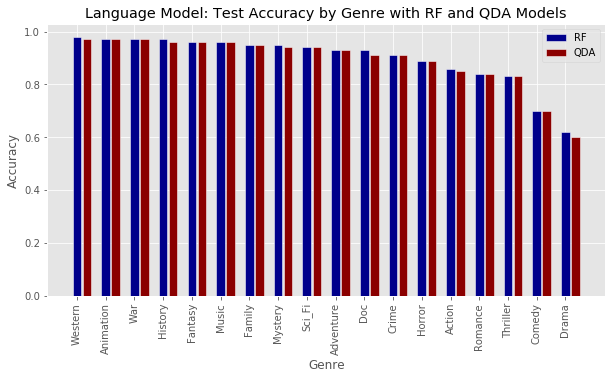

In [75]:
### plot genre accuracy for RF vs. QDA
test_scores_all_rf_df = test_scores_all_rf_df.sort_values(by = 'Accuracy', 
                                                          ascending = False)
test_scores_all_qda_df = test_scores_all_qda_df.sort_values(by = 'Accuracy', 
                                                            ascending = False)

width = 0.3

print
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(1, 1, 1)
rects_1 = ax.bar(range(num_genres), 
       test_scores_all_rf_df.Accuracy, width = width, color = 'darkblue', 
       edgecolor = 'white')
rects_2 = ax.bar(np.repeat(0.35, num_genres) + range(num_genres), 
       test_scores_all_qda_df.Accuracy, width = width, color = 'darkred', 
       edgecolor = 'white')
ax.set_xticks(range(num_genres))
ax.set_xticklabels(test_scores_all_rf_df.index.values, rotation = 90)
ax.set_xlabel("Genre")
ax.set_ylabel("Accuracy")
ax.set_title("Language Model: Test Accuracy by Genre with RF and QDA Models")
ax.legend((rects_1[0], rects_2[0]), ('RF', 'QDA'))
plt.show()